# Toy Problem

This notebook compares results from grid search, random search, and Bayesian search for a 1D problem on the first patient.

## Clinical Goals (Approved Plan)

idx | Name | Description | Type | GoalCriteria | AcceptanceLevel | ParameterValue
-|-|-|-|-|-|-
19 | PTV | At least 95 % volume at 4800 cGy dose | VolumeAtDose | AtLeast | 0.95 | 4800
20 | PTV | At least 99 % volume at 4320 cGy dose | VolumeAtDose | AtLeast | 0.99 | 4320
11 | SpinalCanal |  At most 2080 cGy dose at 0.35 cm$^3$ volume | DoseAtAbsoluteVolume| AtMost | 2080 | 0.35
9 | Lungs | At most 10 % volume at 2000 cGy dose | VolumeAtDose | AtMost | 0.1 | 2000
3 | Heart | At most 15 cm$^3$ volume at 2800 cGy dose | AbsoluteVolumeAtDose | AtMost | 15 | 2800
18 | Chestwall_L | At most 30 cm$^3$ volume at 3000 cGy dose | AbsoluteVolumeAtDose | AtMost | 30 | 3000
14 | Rib | At most 1 cm$^3$ volume at 3200 cGy dose | AbsoluteVolumeAtDose | AtMost | 1 | 3200

## Clinical Goals (Implemented)

idx | Roi | Type | Goal Criteria | AcceptanceLevel | Parameter Value
-|-|-|-|-|-|
0 | PTV | MinDvh | AtLeast | 4800 | 95
1 | PTV | MaxDose | AtMost | 6240 | 0
2 | SpinalCanal | MaxDvh | AtMost | 2080 | 0.67
3 | Lungs | MaxDvh | AtMost | 2000 | 10
4 | Heart | MaxDvh | AtMost | 2800 |  1.84
5 | ChestWall_L | MaxDvh | AtMost | 3000 | 2.04
6 | Rib | MaxDvh | AtMost | 3200 | 0.27

## Objective Terms

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | PTV | Min DVH 4800 cGy to 95% volume | MinDvh | 4800 | 95 | 1
1 | PTV | Max Dose 6240 cGy | MaxDose | 6240 | 0 | 1
2 | SpinalCanal | Max DVH 2080 cGy to 0.67% volume | MaxDvh | 2080 | 0.67 | 1
3 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 1
4 | Heart | Max DVH 2800 cGy to 2% volume | MaxDvh | 2800 | 1.84 | 1
5 | Chestwall_L | Max DVH 3000 cGy to 2.04% volume | MaxDvh | 3000 | 2.04 | 1
6 | Rib | Max DVH 3200 cGy to 0.27% volume | MaxDvh | 3200 | 0.27 | 1

In [1]:
from importlib import reload
import sys

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble as ens
import sklearn.gaussian_process as gp

colors = sns.color_palette()

sys.path.append('../../src')
import plots

In [2]:
def normalize_plans(results):
    # Print success
    flag_0 = len(results[results['Flag'] == 0])
    flag_1 = len(results[results['Flag'] == 1])
    flag_2 = len(results[results['Flag'] == 2])
    print(f'Success: {flag_0}, Not Normalized: {flag_1}, Fail: {flag_2}')
    
    # Normalize plans
    if flag_1 > 0:
        for _, row in results.iterrows():
            scale = 4800/row[0]
            for ii in range(7):
                row[ii] *= scale

In [12]:
def linear_penalty(funcs, pars, goals, results):
    func_vals = 0
    x_grid, _ = plots.format_data(funcs, pars, 'pars')
    x_grid = x_grid[0].values
    ydata, _ = plots.format_data(goals[1:], results, 'goals')
    for ii in range(len(ydata)):
        level = goals.iloc[ii+1]['AcceptanceLevel']
        func_vals += (level - ydata[ii])/level
    return 100*func_vals/(len(goals) - 1)

In [4]:
def plot_dvh(dvh, title):
    plt.figure()
    roi_names = []
    handles = []
    idx = 0
    for roi in dvh.keys():
        if roi != 'Dose':
            handle, = plt.plot(dvh['Dose'], dvh[roi], color=colors[idx])
            plt.plot(dvh_approved['Dose'], dvh_approved[roi], '--', color=colors[idx])
            roi_names.append(roi)
            handles.append(handle)
            idx += 1
    plt.xlabel('Dose (cGy)')
    plt.ylabel('Volume (%)')
    plt.title(title)
    plt.legend(handles=handles, labels=roi_names, bbox_to_anchor=(1, 1))

In [5]:
def print_opt(x, fun, method):
    idx = np.argmin(fun)
    print(f'{method} Rib DoseLevel: {x[idx]:.2f}, Penalty Value: {fun[idx]:.2f}')

In [34]:
# Problem
funcs_full = pd.read_csv('full/funcs.csv')
funcs_toy = pd.read_csv('toy/funcs.csv')
goals = pd.read_csv('goals.csv')

# Approved plan
results_approved = pd.read_pickle('approved/results.npy')
dvh_approved = np.load('approved/dvh.npy', allow_pickle=True).item()

# Default plan
pars_default = pd.read_pickle('default/pars.npy')
results_default = pd.read_pickle('default/results.npy')
fun_default = linear_penalty(funcs_full, pars_default, goals, results_default)
dvh_default = np.load('default/dvh.npy', allow_pickle=True).item()

# Random samples
pars_sample = pd.read_pickle('full/sample/pars.npy')
results_sample = pd.read_pickle('full/sample/results.npy')
normalize_plans(results_sample)
fun_sample = linear_penalty(funcs_full, pars_sample, goals, results_sample)

# Grid search
pars_grid = pd.read_pickle('toy/grid/pars.npy')
results_grid = pd.read_pickle('toy/grid/results.npy')
normalize_plans(results_grid)
fun_grid = linear_penalty(funcs_toy, pars_grid, goals, results_grid)
dvh_grid = np.load('toy/grid/dvh.npy', allow_pickle=True).item()
            
# Random search
results_rand = pd.read_pickle('toy/rand/results.npy')
x_rand = np.load('toy/rand/x_iters.npy').squeeze()
fun_rand = np.load('toy/rand/func_vals.npy')
fun_rand *= -100/(len(goals) - 1)
dvh_rand = np.load('toy/rand/dvh.npy', allow_pickle=True).item()

# Bayesian search
results_bayes = pd.read_pickle('toy/bayes/results.npy')
x_bayes = np.load('toy/bayes/x_iters.npy').squeeze()
fun_bayes = np.load('toy/bayes/func_vals.npy')
fun_bayes *= -100/(len(goals) - 1)
dvh_bayes = np.load('toy/bayes/dvh.npy', allow_pickle=True).item()

Success: 100, Not Normalized: 1, Fail: 0
Success: 24, Not Normalized: 1, Fail: 0


# Random Samples

Results from 100 random samples of DoseValue parameters (except for PTV MinDvh), with 25-100% of parameter ranges.

(<Figure size 432x288 with 2 Axes>, None)

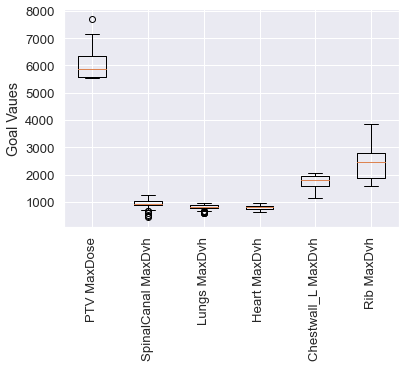

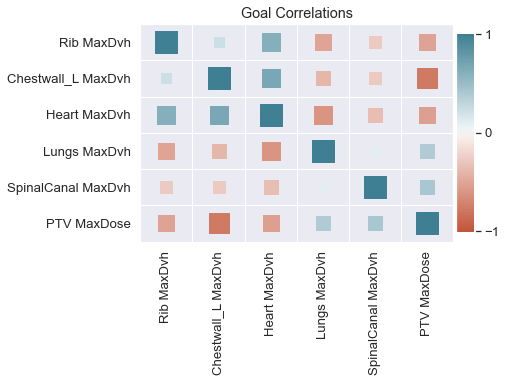

<Figure size 432x288 with 0 Axes>

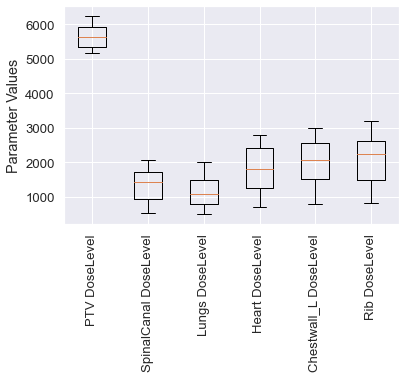

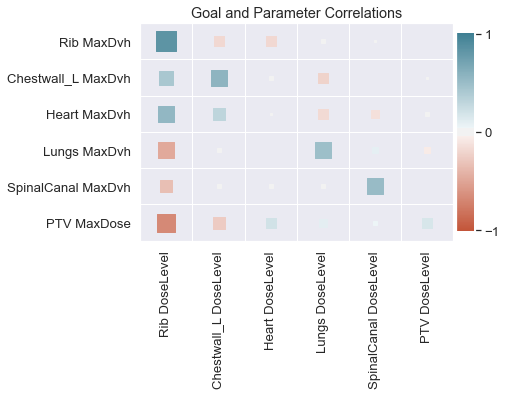

In [8]:
plots.boxplot(goals[1:], results_sample, 'goals')
plt.figure(), plots.corrplot(goals[1:], results_sample, title='Goal Correlations')
plt.figure(), plots.boxplot(funcs_full, pars_sample, 'pars')
plt.figure(), plots.corrplot(goals[1:], results_sample, funcs_full, pars_sample, 'Goal and Parameter Correlations')

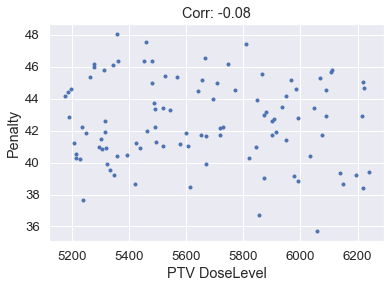

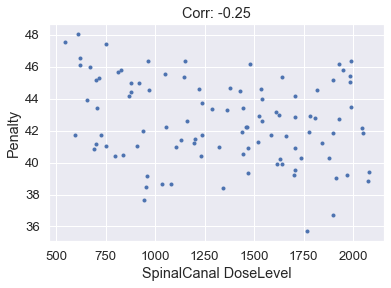

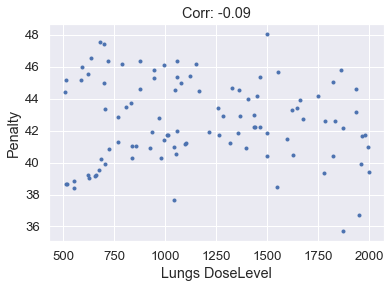

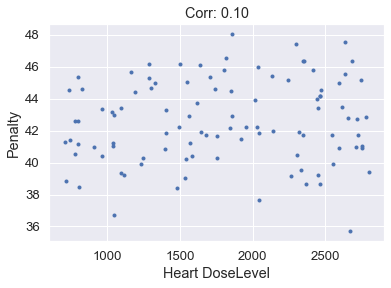

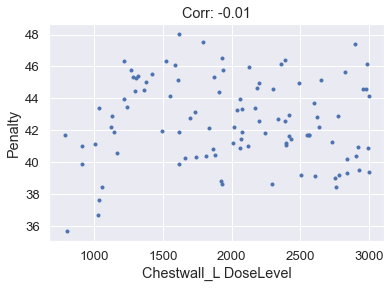

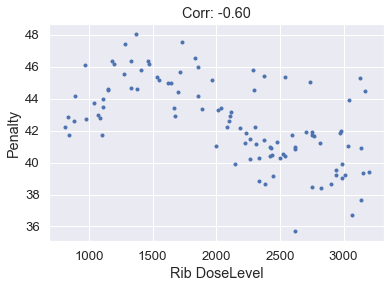

In [14]:
for term in range(1, 7):
    par_vals = pars_sample[pars_sample['Term'] == term]
    par_vals = par_vals
    roi = par_vals['Roi'].values[0]
    dose = par_vals['DoseLevel']
    corr = np.corrcoef(dose, fun_sample)[0, 1]
    plt.figure()
    plt.plot(dose, fun_sample, '.')
    plt.xlabel(f'{roi} DoseLevel')
    plt.ylabel('Penalty')
    plt.title(f'Corr: {corr:.2f}')

# Grid Search

Based on the results above, the rib parameter had the highest correlation with the clinical goals and penalty.
Now we do a grid search over 25-100% of the rib DoseLevel parameter range.

(<Figure size 432x288 with 2 Axes>, None)

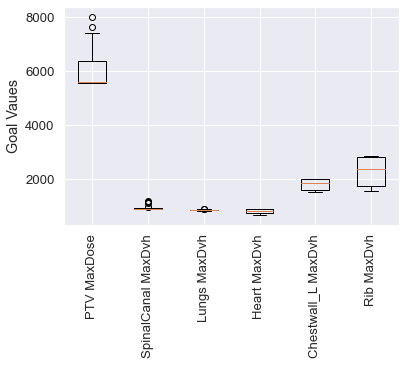

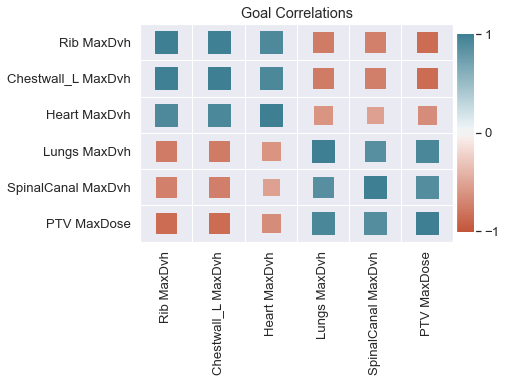

<Figure size 432x288 with 0 Axes>

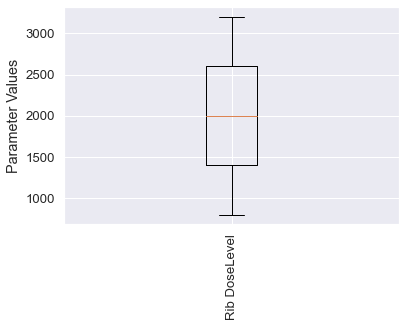

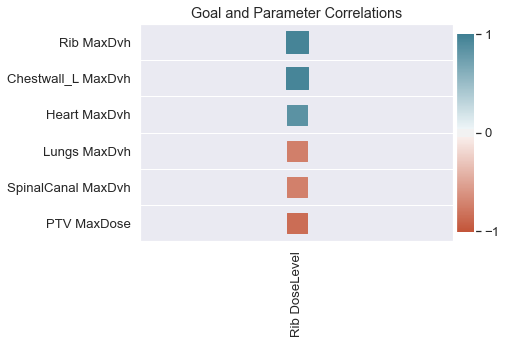

In [10]:
plots.boxplot(goals[1:], results_grid, 'goals')
plt.figure(), plots.corrplot(goals[1:], results_grid, title='Goal Correlations')
plt.figure(), plots.boxplot(funcs_toy, pars_grid, 'pars')
plt.figure(), plots.corrplot(goals[1:], results_grid, funcs_toy, pars_grid, 'Goal and Parameter Correlations')

Text(0, 0.5, 'Plan Utility')

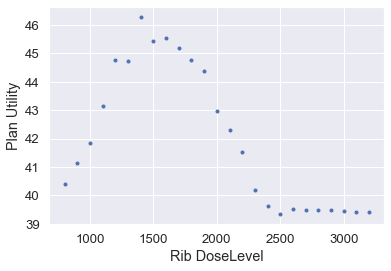

In [35]:
par_vals = pars_grid[pars_grid['Term'] == 6]
par_vals = par_vals
x_grid = par_vals['DoseLevel']
corr = np.corrcoef(x_grid, fun_grid)[0, 1]
plt.plot(x_grid, fun_grid, '.')
plt.xlabel('Rib DoseLevel')
plt.ylabel('Plan Utility')
#plt.title(f'Corr: {corr:.2f}')

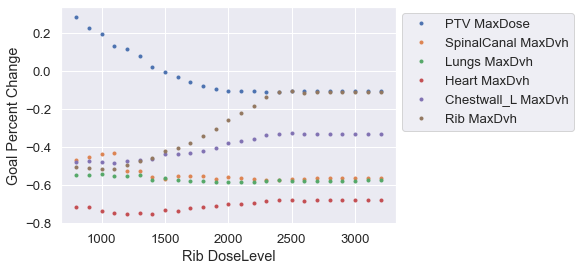

In [147]:
labels = []
for ii in range(1, 7):
    roi = goals.iloc[ii]['Roi']
    goal = goals.iloc[ii]['Type']
    result = (results_grid[ii] - goals.iloc[ii]['AcceptanceLevel'])/goals.iloc[ii]['AcceptanceLevel']
    plt.plot(x_grid, result, '.')
    labels.append(f'{roi} {goal}')
plt.xlabel('Rib DoseLevel')
plt.ylabel('Goal Percent Change')
plt.legend(labels, bbox_to_anchor=(1, 1));

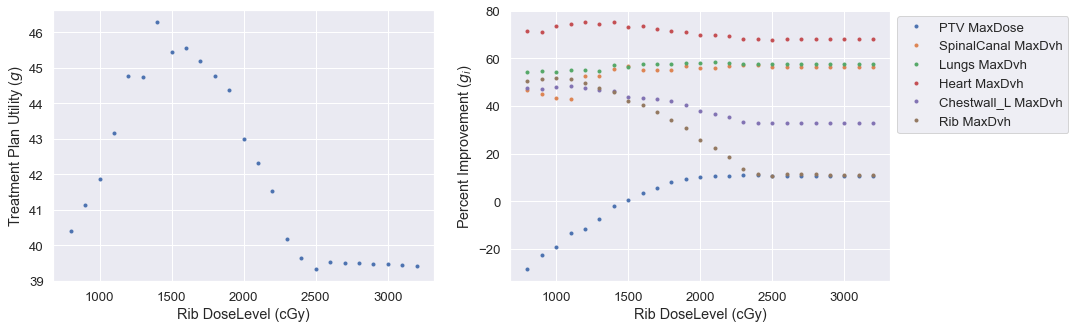

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Penalty function
par_vals = pars_grid[pars_grid['Term'] == 6]
par_vals = par_vals
x_grid = par_vals['DoseLevel']
ax[0].plot(x_grid, fun_grid, '.')
ax[0].set_xlabel('Rib DoseLevel (cGy)')
ax[0].set_ylabel('Treatment Plan Utility ($g$)')

# Percent Improvement
labels = []
for ii in range(1, 7):
    roi = goals.iloc[ii]['Roi']
    goal = goals.iloc[ii]['Type']
    result = 100*(results_grid[ii] - goals.iloc[ii]['AcceptanceLevel'])/goals.iloc[ii]['AcceptanceLevel']
    plt.plot(x_grid, -result, '.')
    labels.append(f'{roi} {goal}')
ax[1].set_xlabel('Rib DoseLevel (cGy)')
ax[1].set_ylabel('Percent Improvement ($g_i$)')
plt.legend(labels, bbox_to_anchor=(1, 1));

# Compare Search Methods

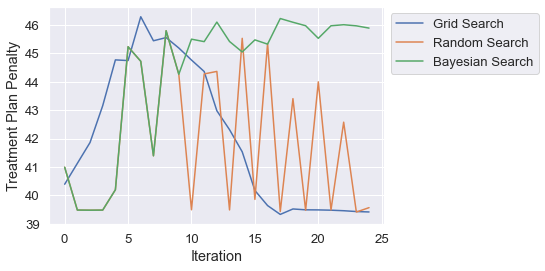

In [38]:
# Compare convergence of optimization methods
plt.plot(fun_grid)
plt.plot(fun_rand)
plt.plot(fun_bayes)
plt.xlabel('Iteration')
plt.ylabel('Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search'],
           bbox_to_anchor=(1, 1));

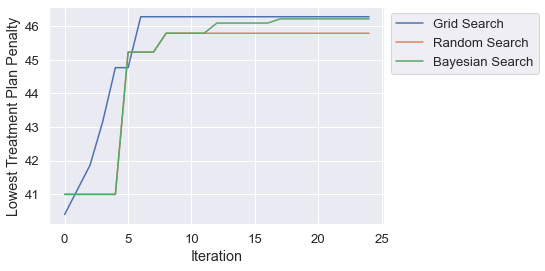

In [43]:
# Compare convergence of optimization methods
plt.plot(np.maximum.accumulate(fun_grid))
plt.plot(np.maximum.accumulate(fun_rand))
plt.plot(np.maximum.accumulate(fun_bayes))
plt.xlabel('Iteration')
plt.ylabel('Lowest Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search'],
           bbox_to_anchor=(1, 1));

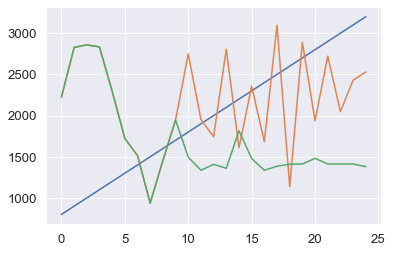

In [59]:
plt.plot(list(x_grid))
plt.plot(x_rand)
plt.plot(x_bayes)

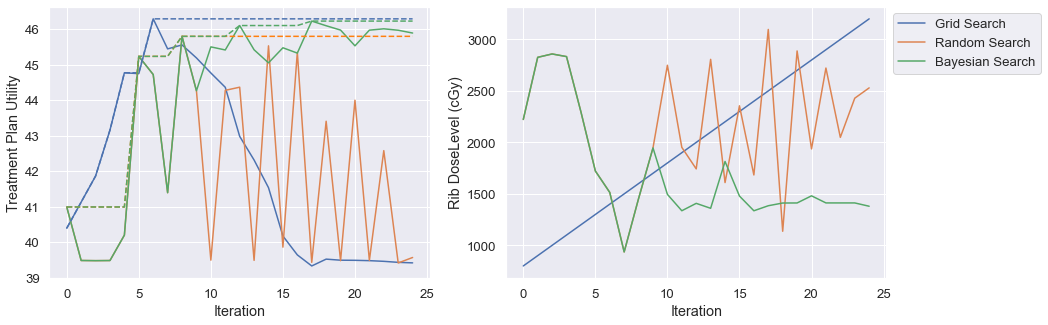

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# function value
ax[0].plot(fun_grid)
ax[0].plot(fun_rand)
ax[0].plot(fun_bayes)
ax[0].plot(np.maximum.accumulate(fun_grid), 'b--')
ax[0].plot(np.maximum.accumulate(fun_rand), '--', color=colors[1])
ax[0].plot(np.maximum.accumulate(fun_bayes), 'g--')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Treatment Plan Utility')


# parameter value
ax[1].plot(list(x_grid))
ax[1].plot(x_rand)
ax[1].plot(x_bayes)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Rib DoseLevel (cGy)')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search'],
           bbox_to_anchor=(1, 1));

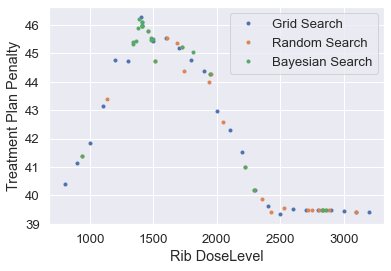

In [41]:
# Compare penalty value results
plt.plot(x_grid, fun_grid, '.')
plt.plot(x_rand, fun_rand, '.')
plt.plot(x_bayes, fun_bayes, '.')
plt.xlabel('Rib DoseLevel')
plt.ylabel('Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search'],
           bbox_to_anchor=(1, 1));

In [15]:
# Compare optimal penalty values
    
print(f'Approved Plan Penalty Value: {linear_penalty(funcs_toy, pars_default, goals, results_approved)[0]:.2f}')
print_opt([3200], fun_default, 'Default Plan')
print_opt(x_grid, fun_grid, 'Grid Search')
print_opt(x_rand, fun_rand, 'Random Search')
print_opt(x_bayes, fun_bayes, 'Bayesian Search')

Approved Plan Penalty Value: -2.42
Default Plan Rib DoseLevel: 3200.00, Penalty Value: -2.37
Grid Search Rib DoseLevel: 800.00, Penalty Value: -2.78
Random Search Rib DoseLevel: 1454.38, Penalty Value: -2.75
Bayesian Search Rib DoseLevel: 1384.78, Penalty Value: -2.77


In [16]:
# Compare goal results
res_names = ['DF', 'GS', 'RS', 'BS']
results = [results_default, results_grid[results_grid['Sample'] == np.argmin(fun_grid)].reset_index(drop=True),
           results_rand, results_bayes]

for goal, row in goals.iterrows():
    print(f"ROI: {row['Roi']}, Type: {row['Type']}")
    level = row['AcceptanceLevel']
    for ii in range(len(results)):
        res = results[ii][goal][0]
        diff_goal = 100*(res - level)/level
        app = results_approved[goal][0]
        diff_app = 100*(res - app)/app
        print(f'{res_names[ii]} Value: {res:.2f}, % Diff Goal: {diff_goal:.2f}, % Diff App: {diff_app:.2f}')
    print()

ROI: PTV, Type: MinDvh
DF Value: 4800.00, % Diff Goal: 0.00, % Diff App: -0.00
GS Value: 4800.00, % Diff Goal: 0.00, % Diff App: -0.00
RS Value: 4800.00, % Diff Goal: -0.00, % Diff App: -0.00
BS Value: 4800.00, % Diff Goal: 0.00, % Diff App: -0.00

ROI: PTV, Type: MaxDose
DF Value: 5572.02, % Diff Goal: -10.70, % Diff App: -8.30
GS Value: 6371.04, % Diff Goal: 2.10, % Diff App: 4.85
RS Value: 6269.78, % Diff Goal: 0.48, % Diff App: 3.19
BS Value: 6428.89, % Diff Goal: 3.03, % Diff App: 5.81

ROI: SpinalCanal, Type: MaxDvh
DF Value: 906.26, % Diff Goal: -56.43, % Diff App: -4.29
GS Value: 922.23, % Diff Goal: -55.66, % Diff App: -2.60
RS Value: 886.42, % Diff Goal: -57.38, % Diff App: -6.38
BS Value: 882.84, % Diff Goal: -57.56, % Diff App: -6.76

ROI: Lungs, Type: MaxDvh
DF Value: 849.81, % Diff Goal: -57.51, % Diff App: 8.46
GS Value: 858.64, % Diff Goal: -57.07, % Diff App: 9.58
RS Value: 874.84, % Diff Goal: -56.26, % Diff App: 11.65
BS Value: 875.51, % Diff Goal: -56.22, % Diff App

In [126]:
list(pars_default['DoseLevel'])[1:]

[6240.0, 2080.0, 2000.0, 2800.0, 3000.0, 3200.0]

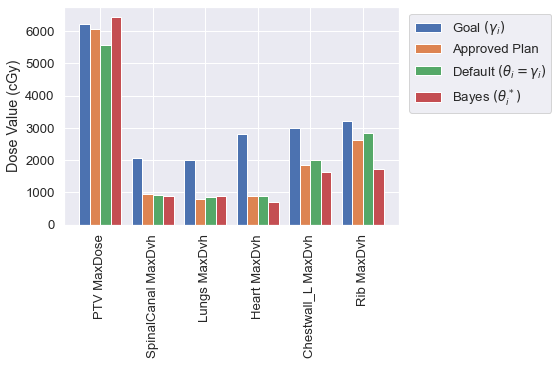

In [158]:
N = 6
men_means = (20, 35, 30, 35, 27)
women_means = (25, 32, 34, 20, 25)

ind = 1.5*np.arange(N) 
width = 0.3
plt.bar(ind - 3/2*width, list(pars_default['DoseLevel'])[1:], width, label='Goal $(\gamma_i)$')
plt.bar(ind - width/2, list(results_approved.iloc[0])[3:], width, label='Approved Plan')
plt.bar(ind + width/2, list(results_default.iloc[0])[3:], width, label=r'Default $(\theta_i = \gamma_i)$')
plt.bar(ind + 3/2*width, list(results_bayes.iloc[0])[3:], width, label=r'Bayes $(\theta_i^*)$')

plt.ylabel('Dose Value (cGy)')

plt.xticks(ind, labels, rotation=90)
plt.legend(bbox_to_anchor=(1.475, 1))
plt.show()

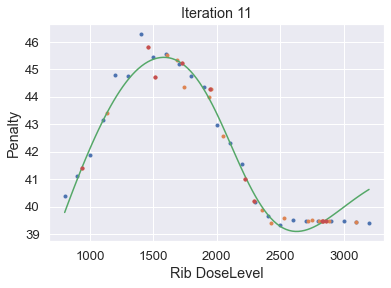

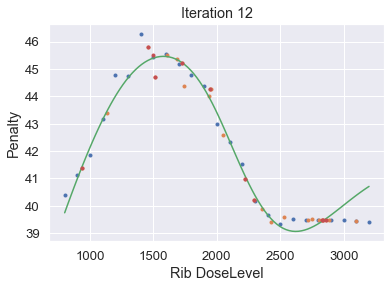

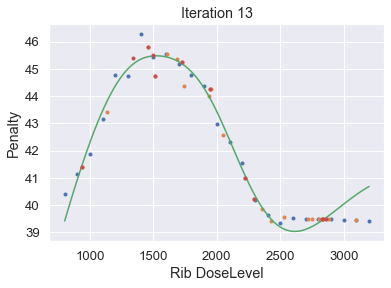

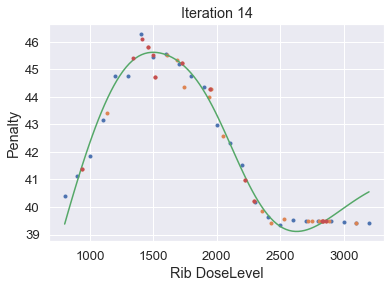

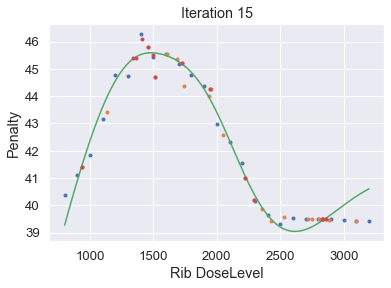

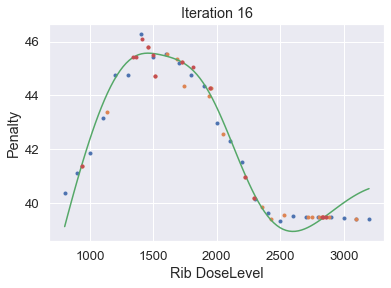

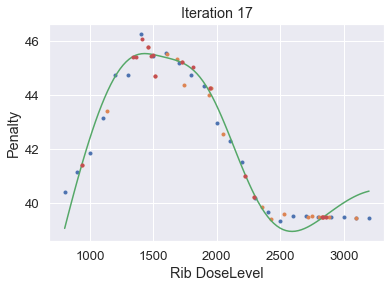

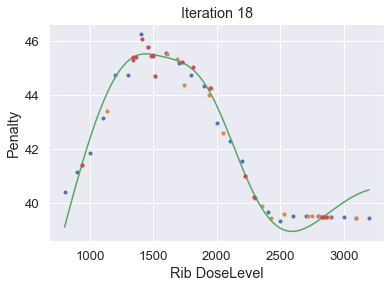

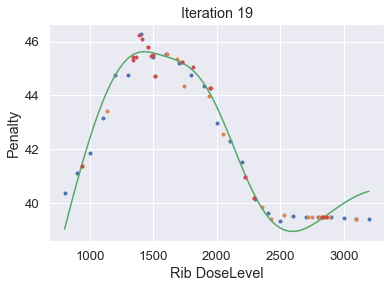

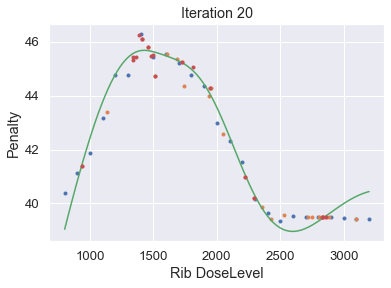

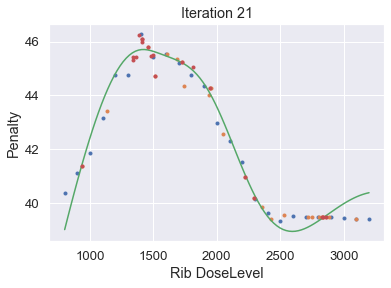

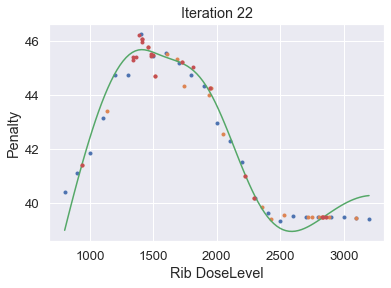

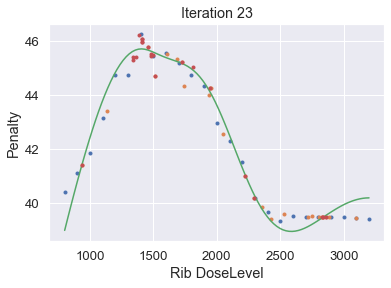

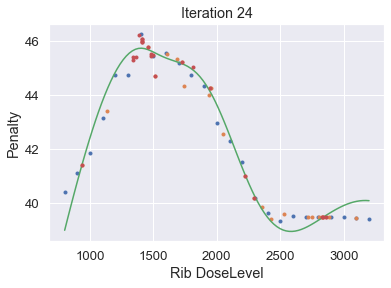

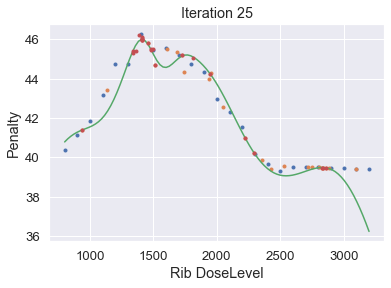

In [71]:
# Guassian Process

# Should save the surrogate models next time...
# It says the kernels are tuned, so can't assume it's what I've input

x_vals = np.linspace(800, 3200, 100)
for idx in range(10, 25):
    plt.figure()  
    plt.plot(x_grid, fun_grid, '.')
    plt.plot(x_rand, fun_rand, '.')
    model = gp.GaussianProcessRegressor(kernel=1**2 * gp.kernels.Matern(length_scale=1, nu=2.5) + gp.kernels.WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, random_state=209652396)
    model.fit(x_bayes[:idx].reshape(-1, 1), fun_bayes[:idx] )   
    y_vals = model.predict(x_vals.reshape(-1, 1))
    plt.plot(x_vals, y_vals)
    plt.plot(x_bayes[:idx], fun_bayes[:idx], '.')
    #plt.plot(x_bayes[idx], fun_bayes[idx], '.')
    plt.xlabel('Rib DoseLevel')
    plt.ylabel('Penalty')
    plt.title(f'Iteration {idx+1}')
    
# Add standard deviation?

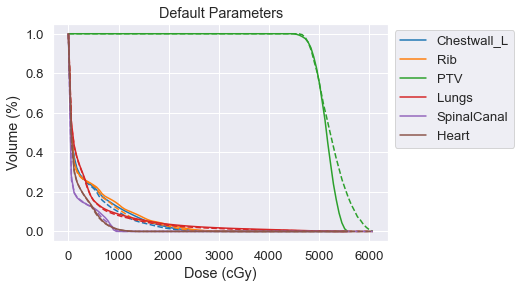

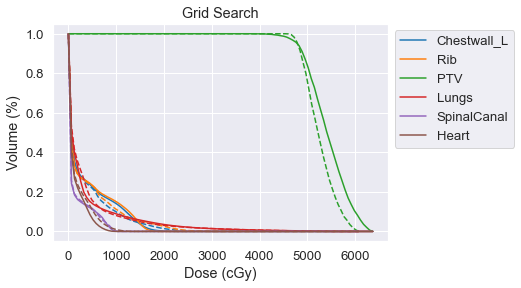

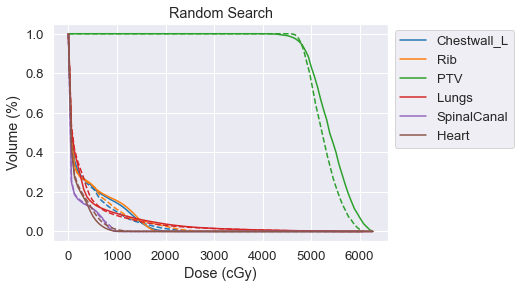

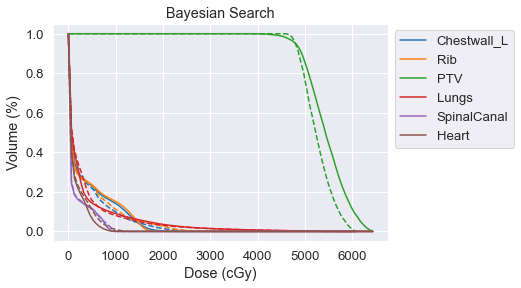

In [18]:
# Dose-volume histograms
   
plot_dvh(dvh_default, 'Default Parameters')
plot_dvh(dvh_grid, 'Grid Search')
plot_dvh(dvh_rand, 'Random Search')
plot_dvh(dvh_bayes, 'Bayesian Search')

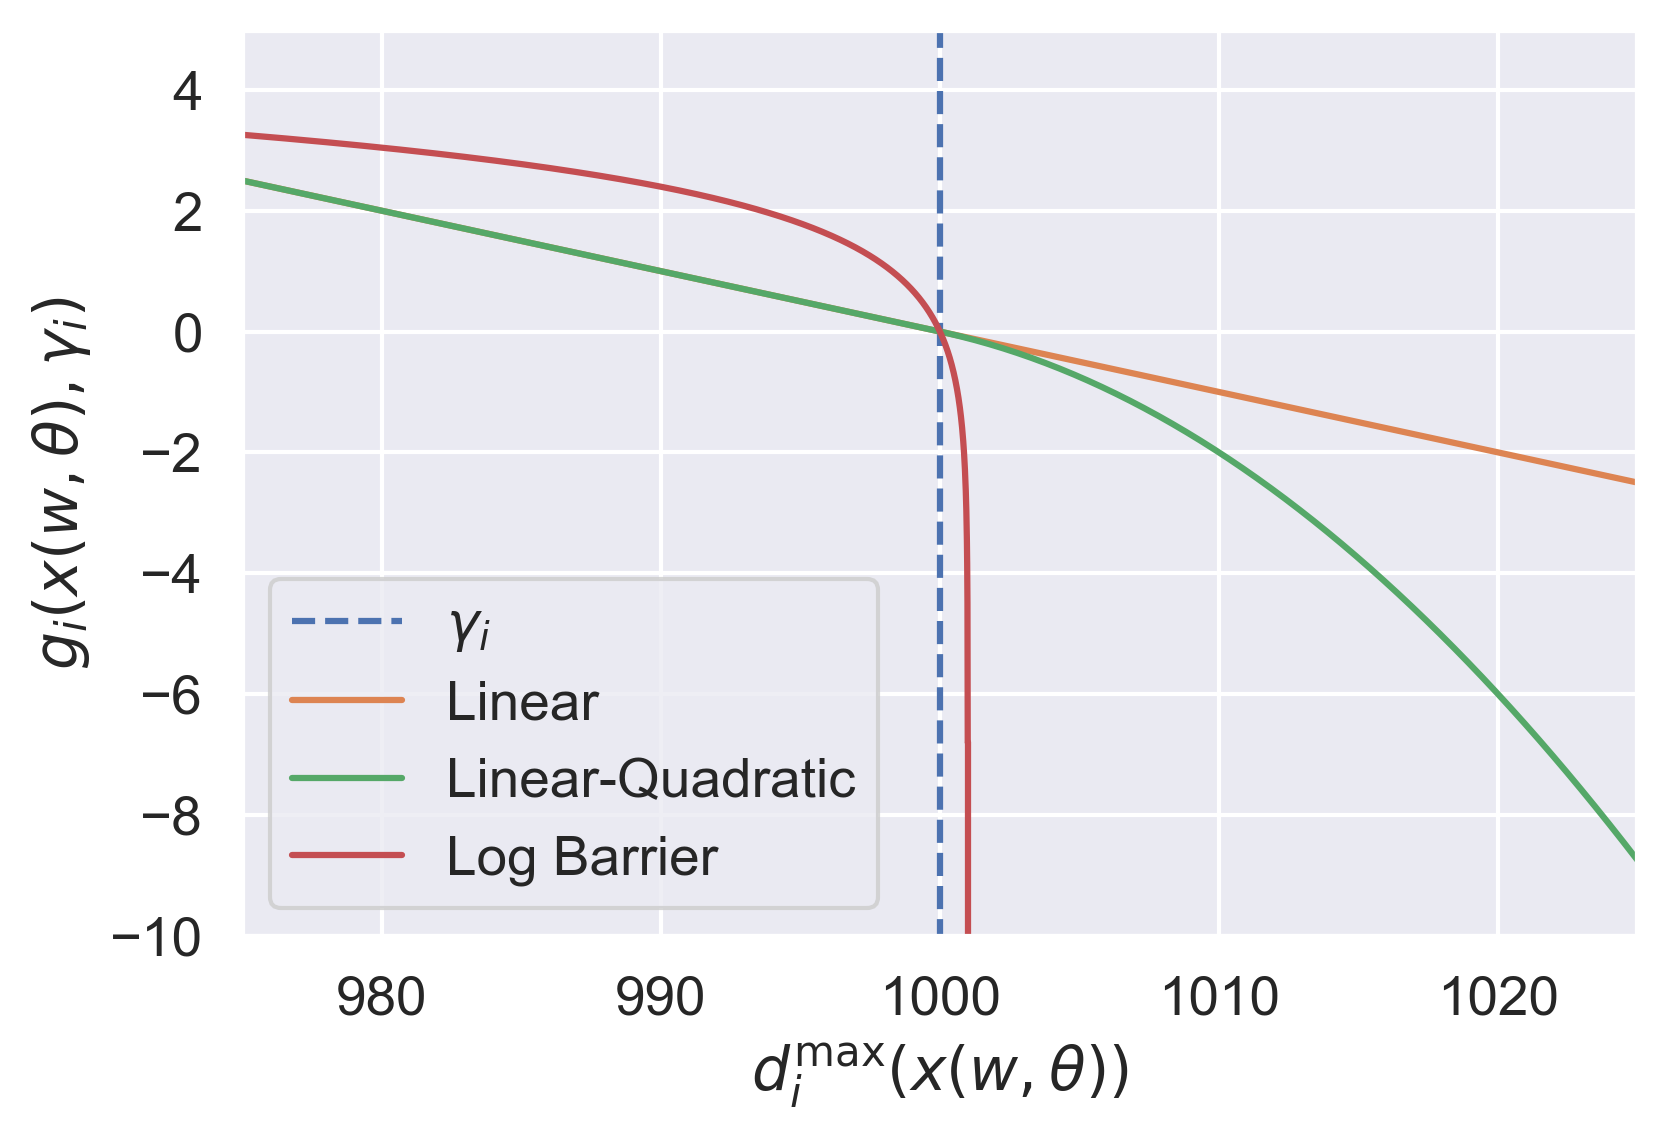

In [246]:
# OAR score functions

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

max_dose = 1000
dose_vals = np.linspace(max_dose - 25, max_dose + 25, 100)
plt.plot([max_dose, max_dose], [-100, 50], '--')
plt.xlabel(r'$d_i^{\max}(x(w, \theta))$')
plt.ylabel(r'$g_i(x(w,\theta), \gamma_i)$')

# linear score
f = lambda x: 100*(max_dose - x)/max_dose
plt.plot(dose_vals, f(dose_vals))

# linear-quadratic score
g = lambda x: (x < max_dose)*f(x) - (x >= max_dose)*(f(x + max_dose/200)**2 - 1/4)
plt.plot(dose_vals, g(dose_vals))


# log barrier
def h(x):
    if x <= max_dose + 1:
        return np.log(max_dose - x + 1)
    else:
        return -np.inf
dose_vals = np.linspace(max_dose - 100, max_dose + 1.1, 10000)
plt.plot(dose_vals, [h(x) for x in dose_vals])
plt.plot([dose_vals[-11], dose_vals[-11]], [h(dose_vals[-11]), -100], c=colors[3])


plt.xlim([975, 1025])
plt.ylim([-10, 5])
plt.legend(['$\gamma_i$', 'Linear', 'Linear-Quadratic', 'Log Barrier'])#, bbox_to_anchor=(1.5,1))

#plt.xlim([990, 1010])
#plt.ylim([-10, 10])

In [231]:
h(dose_vals[-11])

-6.803295258721336

(-5.0, 5.0)

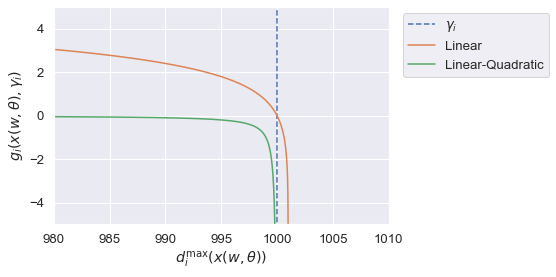

In [192]:
# PTV score functions

max_dose = 1000
dose_vals = np.linspace(max_dose - 20, max_dose + 1.1, 1000)
plt.plot([max_dose, max_dose], [-10, 5], '--')
plt.xlabel(r'$d_i^{\max}(x(w, \theta))$')
plt.ylabel(r'$g_i(x(w,\theta), \gamma_i)$')

# log barrier
def f(x):
    if x <= max_dose + 1:
        return np.log(max_dose - x + 1)
    else:
        return -np.inf
plt.plot(dose_vals, [f(x) for x in dose_vals])
#plt.plot([1020, 1020], [-10, -5.25], c=colors[1])


# # inverse barrier
def g(x):
    if x <= max_dose:
        return -1/(max_dose - x)
    else:
        return -np.inf
plt.plot(dose_vals, [g(x) for x in dose_vals])
plt.legend(['$\gamma_i$', 'Linear', 'Linear-Quadratic'], bbox_to_anchor=(1.5,1))
plt.xlim([980, 1010])
plt.ylim([-5, 5])

In [199]:
f(dose_vals[-6])

-5.1839881809017205

In [200]:
dose_vals[-6]

1000.9943943943944

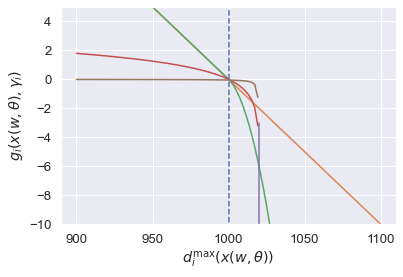

In [107]:
# Different score functions

max_dose = 1000
dose_vals = np.linspace(max_dose - dd, max_dose + dd, 100)

plt.ylim([-10, 5])

# linear score
f = lambda x: 100*(max_dose - x)/max_dose
plt.plot(dose_vals, f(dose_vals))


# linear-quadratic score
dx = -max_dose/200
dy = 1/4
g = lambda x: (x < max_dose)*f(x) - (x >= max_dose)*(f(x - dx)**2 - dy)
plt.plot(dose_vals, g(dose_vals))

# log barrier
def lb(x):
    if x <= 1.02*max_dose:
        return np.log(1.02*max_dose - x) - np.log(0.02*max_dose)
    else:
        return -np.inf
plt.plot(dose_vals, [lb(x) for x in dose_vals])
plt.plot([1.02*max_dose, 1.02*max_dose], [lb(1019), -100])

# inverse barrier    
def ib(x):
    if x <= 1.02*max_dose:
        return 1/(1.02*max_dose - x)
    else:
        return np.inf
plt.plot(dose_vals, [-ib(x) for x in dose_vals])



# f = lambda x: 100*(x - max_val)/max_val
# fp = lambda x: 100/max_val*np.ones_like(x)
# g = lambda x: f(x - dx)**2 + dy
# gp = lambda x: 2*f(x - dx)*fp(x - dx)
# h = lambda x: (x <= max_val)*f(x) + (x > max_val)*g(x)
# hp = lambda x: (x <= max_val)*fp(x) + (x > max_val)*gp(x)

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# res_val = np.linspace(0.5*max_val, 1.5*max_val, 1000)
# ax[0].plot(res_val, f(res_val))
# ax[0].plot(res_val, g(res_val))
# ax[0].plot(res_val, h(res_val))
# ax[0].set_xlabel('Result Dose')
# ax[0].set_ylabel('Score')
# ax[0].set_xlim([max_val - 100, max_val + 100])
# ax[0].set_ylim([-2, 2])

# ax[1].plot(res_val, fp(res_val))
# ax[1].plot(res_val, gp(res_val))
# ax[1].plot(res_val, hp(res_val))
# ax[1].set_xlabel('Result Dose')
# ax[1].set_ylabel('Derivative')
# plt.legend(['Linear', 'Quadratic', 'Score']);
#plt.ylim([-5, 5])